开始之前记得先检查一下有没有用GPU

# 安装

安装库的指令，这三行代码运行一次就可以了，可能花几分钟

In [15]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install pretty_midi

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


引用的包放在这里，后期如果有import其他的包，最好也加在这里。这里的参数基本不需要改。

In [16]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
import os

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

# 读文件

这一部分是一些基础的函数，具体的功能看注释。两个画图的代码暂时没有用到，如果汇报的时候用RNN再来搞这个。

In [17]:
# 播放音符
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform, rate=_SAMPLING_RATE)

# 从midi中读取音符
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

# 绘制钢琴卷帘
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

# 检查音量分布
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
  
  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

# 创建midi文件
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

## 读训练集

读训练集内所有文件的名称。我是把文件直接拖到左边，所以这一步一定！一定！要在上传测试数据之前，并且只能运行一次！！！如果你跑着跑着混乱了，不确定对不对，可以测试一下

```
if test_file_name in filnames:
  print（'Yes!'）
```


输出Yes的话就得把测试数据删了重新跑一次这两行。

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
filenames = os.listdir('/content/drive/MyDrive/API_Group/RELEASE2.0_mid_unquant') # 读指定文件夹下所有的文件名
filenames = filenames[1:-1] # 因为我是直接把文件拖到左边，所以会有.config和sample文件夹，这一行是用来删除这两个的。你如果有其他文件目录，可以适当修改。

把训练集里的所有音符都放到一个list里，如果是我发的那个数据集，读完应该有20多万个。

In [20]:
# 读音符
all_notes = []

for f in filenames:
  path = '/content/drive/MyDrive/API_Group/RELEASE2.0_mid_unquant/'+ f
  notes = midi_to_notes(path)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

# 检查数量
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 200194


保证训练集文件名正确之后，就可以上传测试数据了。下面这行读测试数据。

In [21]:
raw_notes = midi_to_notes('/content/drive/MyDrive/API_Group/carnon_solo.mid')

测试一下测试数据是否正常。如果测试音频很长，display_audio那行可能会要几分钟时间。

In [22]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name='Acoustic Grand Piano')

display_audio(example_pm)

Output hidden; open in https://colab.research.google.com to view.

创建dataset。输出应该是：TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [23]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

# 模型创建和训练

创建sequence。所有的函数基本都不需要改，后同。



In [24]:
def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)
  
  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

sequence创建和参数设置。**这里有需要调参的第一个地方：seq_length**，表示一次输入的参考序列的长度。vocab_size是pitch的总数，不建议改。这个单元格的输出也跟这个参数有关，应该是shape=(seq_length, 3)

In [25]:
seq_length = 50
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)    
seq_ds.element_spec

(TensorSpec(shape=(50, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

样本批处理，batch_size可改可不改。

In [26]:
batch_size = 512
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

创建和输出模型。

In [27]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

这里要调的地方比较多。主要是**网络结构**和learning_rate，optimizer和loss_weight也可以改。网络结构可以参考网上其他人的。

In [28]:
input_shape = (seq_length, 3)
learning_rate = 3e-4

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128,return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(256,return_sequences=True)(x)
x = tf.keras.layers.LSTM(512)(x)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(
    loss=loss,
    loss_weights={    # (音高,step和前面的距离,多久)
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 3)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 50, 128)      67584       ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 50, 256)      394240      ['lstm[0][0]']                   
                                                                                                  
 lstm_2 (LSTM)                  (None, 512)          1574912     ['lstm_1[0][0]']                 
                                                                                              

准备训练，callbacks跑一次就可以了。

In [29]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

重新训练从这里开始，epochs的数量应该在50左右就差不多，不过你可以定大一点，因为有设置early stopping。按我现在的参数，训练速度差不多是3-4s一个epoch，如果慢得太离谱，记得检查一下有没有开GPU。

Epoch 1/300
390/390 [==============================] - 67s 103ms/step - loss: 0.3730 - duration_loss: 0.0540 - pitch_loss: 3.8703 - step_loss: 0.1256
Epoch 2/300
390/390 [==============================] - 42s 108ms/step - loss: 0.3292 - duration_loss: 0.0395 - pitch_loss: 3.3773 - step_loss: 0.1208
Epoch 3/300
390/390 [==============================] - 41s 106ms/step - loss: 0.3256 - duration_loss: 0.0403 - pitch_loss: 3.4103 - step_loss: 0.1148
Epoch 4/300
390/390 [==============================] - 41s 106ms/step - loss: 0.2938 - duration_loss: 0.0396 - pitch_loss: 3.3732 - step_loss: 0.0855
Epoch 5/300
390/390 [==============================] - 41s 106ms/step - loss: 0.2922 - duration_loss: 0.0393 - pitch_loss: 3.3707 - step_loss: 0.0844
Epoch 6/300
390/390 [==============================] - 41s 106ms/step - loss: 0.2903 - duration_loss: 0.0393 - pitch_loss: 3.3413 - step_loss: 0.0840
Epoch 7/300
390/390 [==============================] - 42s 108ms/step - loss: 0.2844 - duration_loss

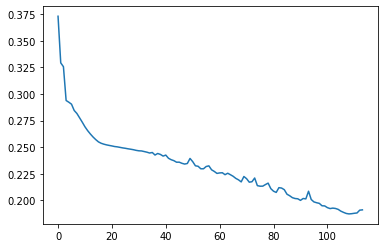

CPU times: user 1h 20min 1s, sys: 1min 17s, total: 1h 21min 19s
Wall time: 1h 47min 10s


In [30]:
%%time
epochs = 300

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [31]:
model.save_weights("ckpt")

In [32]:
model.save('model_RNN', save_format='tf')

In [33]:
!zip -r /content/model_RNN.zip /content/model_RNN

  adding: content/model_RNN/ (stored 0%)
  adding: content/model_RNN/keras_metadata.pb (deflated 92%)
  adding: content/model_RNN/variables/ (stored 0%)
  adding: content/model_RNN/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/model_RNN/variables/variables.index (deflated 70%)
  adding: content/model_RNN/assets/ (stored 0%)
  adding: content/model_RNN/saved_model.pb (deflated 90%)


# 生成音乐

In [34]:
def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  """Generates a note IDs using a trained sequence model."""


  

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
 
  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

# 新段落

**这部分要调的参数有temperature**。for循环内是生成的过程。

```
# if abs(pitch - raw_notes.iloc[i+seq_length]['pitch']) > 1:
if np.random.rand(1)[0] > 0.2:
  pitch = raw_notes.iloc[i+seq_length]['pitch']
```
是我加的判断条件，要看原模型效果直接删掉就好。**你可以改成任何你自己喜欢的处理方式。**


In [35]:
temperature = 0.5
num_predictions = min(120, len(raw_notes)-seq_length)

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

generated_notes = []
prev_start = raw_notes.iloc[seq_length]['start']

for i in range(num_predictions):
  input_notes = (sample_notes[i:i+seq_length] / np.array([vocab_size, 1, 1]))
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  # if abs(pitch - raw_notes.iloc[i+seq_length]['pitch']) > 1:
  if np.random.rand(1)[0] > 0.2:
    pitch = raw_notes.iloc[i+seq_length]['pitch']
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

comb_notes = raw_notes.iloc[:seq_length].append(generated_notes)

1/1 [==============================] - 0s 25ms/step


播放生成的结果。并存在output.mid文件里。这里播放的是comb_notes，也就是前面会有一个seq_length的音是没有改的。如果只听生成的部分，可以把comb_notes改成gengerated_notes。

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    comb_notes, out_file=out_file, instrument_name='Acoustic Grand Piano')
display_audio(out_pm)